In [7]:
import numpy as np
import matplotlib.pyplot as plt

from time import sleep

In [5]:
ga_run = np.load('ga_runs/18-04-10-21-42-02.npz')

individuals = ga_run['individuals']
objectives = ga_run['objectives']
fitnesses = ga_run['fitnesses']

In [12]:
objectives[0]

array([[7.7512783e-07, 9.9718577e-01],
       [9.1779861e-04, 5.0545472e-01],
       [8.0436075e-07, 9.9362046e-01],
       ...,
       [1.3931000e-02, 2.0507342e-01],
       [2.1211864e-02, 1.7061204e-01],
       [7.5926164e-07, 9.9461675e-01]], dtype=float32)

<IPython.core.display.Javascript object>


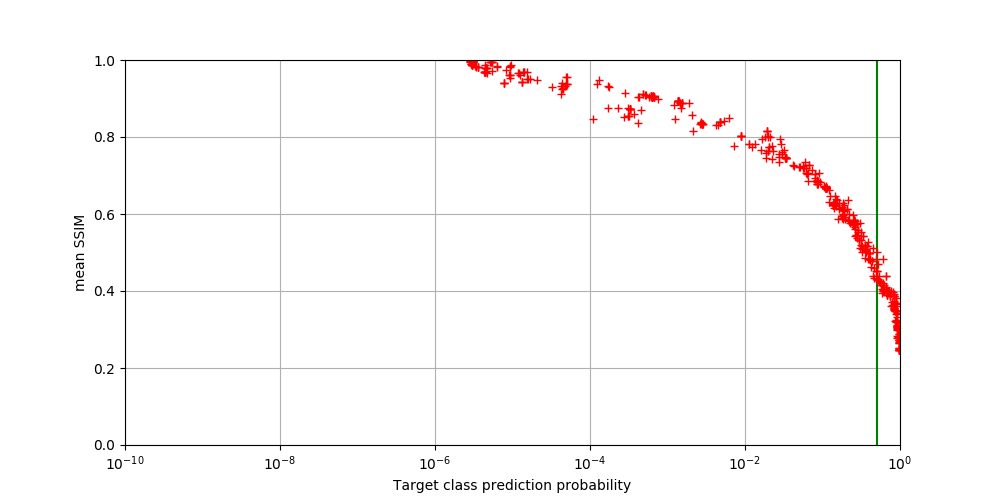

In [17]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,5))
# fig.tight_layout()

ax.set_xlim(0.0000000001, 1)
ax.set_xlabel('Target class prediction probability')
ax.set_ylim(0, 1)
ax.set_ylabel('mean SSIM')
ax.set_xscale('log')
ax.grid(axis='both')
ax.vlines(0.5, -1, 1, colors='g')

for epoch, curr_objectives in enumerate(objectives):
    ax.lines = []
    ax.plot(*curr_objectives.transpose(), 'r+')
    
    fig.canvas.set_window_title('Current generation: {}'.format(epoch))
    fig.canvas.draw()
    
    sleep(0.05)

<IPython.core.display.Javascript object>


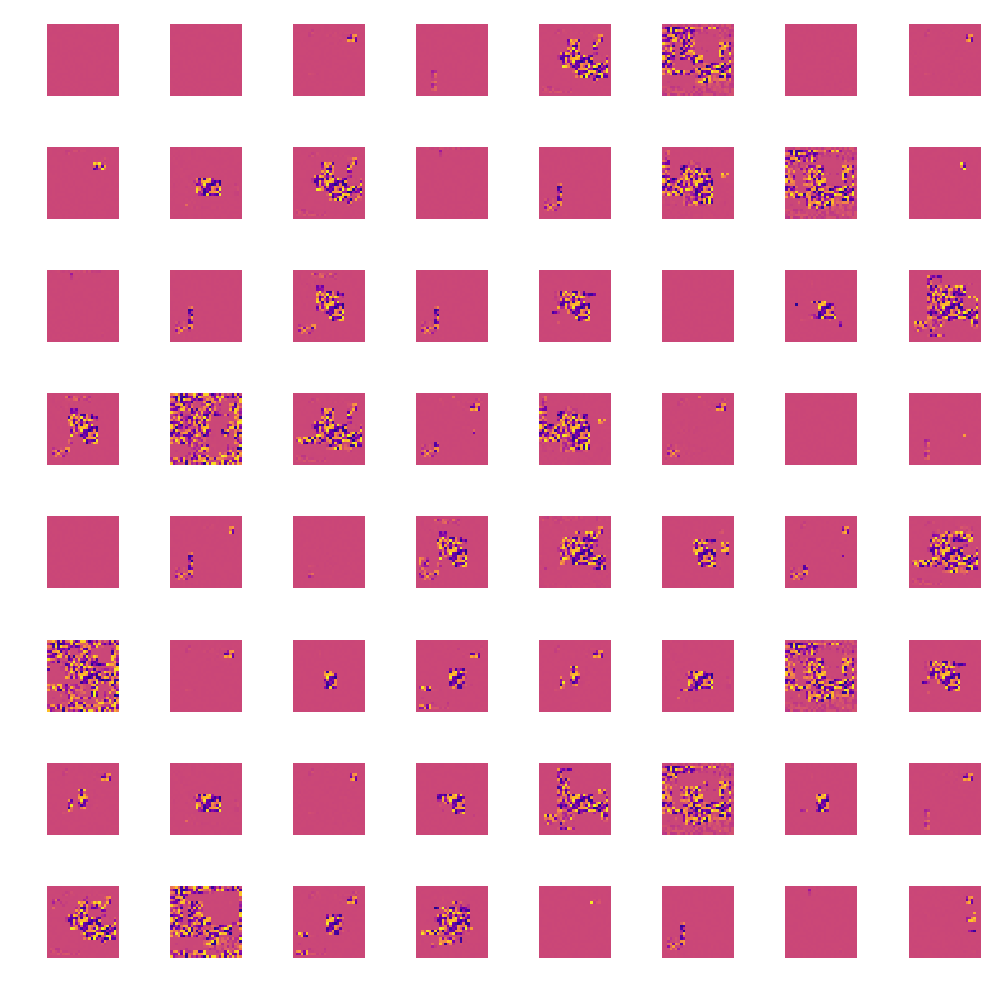

In [19]:
%matplotlib notebook

fig, ax = plt.subplots(8, 8, figsize=(10, 10))
fig.tight_layout()

for i in range(64):
    if i > len(individuals):
        break
    
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(individuals[i], cmap='plasma', vmin=-1, vmax=1)